<a href="https://colab.research.google.com/github/Mubashar-Bashir/Langchain_EcoSystem/blob/main/HIL_interrupt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Case 0 - Basic Usage

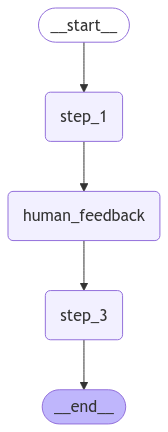

In [115]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from langgraph.types import Command, interrupt


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback--- ")
    print(f"Initial Input from User pass state>>>: {state['input']}") #state input value=A
    feedback = interrupt(value=input("Enter New Value: ")) #{state["input"]} #updates =Value = B
    print(f"\n\n[GOT BACK FROM HUMAN AFTER INTERRUPT:]\n\n", feedback)
    return {"user_feedback": feedback}


def step_3(state):
    print("---Step 3---")
    print(state["input"])
    print(state["user_feedback"])
    return state



builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [116]:
# Config
# Input

# Input
initial_input = {"input": " A"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"): #value= A , stream_mode=update="B"
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback--- 
Initial Input from User pass state>>>:  A
Enter New Value: B
{'__interrupt__': (Interrupt(value='B', resumable=True, ns=['human_feedback:be87f5d1-4dbb-6c6e-4ccf-aaf442d73ace'], when='during'),)}




In [117]:
# HOW TO RESUME
# Continue the graph execution
for event in graph.stream(
    Command(resume="goto next step-4"),
    thread,
    stream_mode="updates"
):
    print(event)
    print("\n")

---human_feedback--- 
Initial Input from User pass state>>>:  A
Enter New Value: C


[GOT BACK FROM HUMAN AFTER INTERRUPT:]

 goto next step-4
{'human_feedback': {'user_feedback': 'goto next step-4'}}


---Step 3---
 A
goto next step-4
{'step_3': {'input': ' A', 'user_feedback': 'goto next step-4'}}




In [101]:
thread = {"configurable": {"thread_id": "6"}}

In [102]:
graph.update_state(thread, {"input": "G"})

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1efc615c-8ef9-6766-8000-19e348e7f734'}}

In [113]:
graph.get_state(thread)

StateSnapshot(values={'input': ' A'}, next=('human_feedback',), config={'configurable': {'thread_id': '5', 'checkpoint_ns': '', 'checkpoint_id': '1efc6174-5b81-6a07-8001-22eeb070882c'}}, metadata={'source': 'loop', 'writes': {'step_1': None}, 'thread_id': '5', 'step': 1, 'parents': {}}, created_at='2024-12-29T19:01:12.801462+00:00', parent_config={'configurable': {'thread_id': '5', 'checkpoint_ns': '', 'checkpoint_id': '1efc6174-5b77-6e99-8000-f114cb20d7a9'}}, tasks=(PregelTask(id='4b95483a-6d88-5a20-0291-b6583821cb58', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(Interrupt(value='B', resumable=True, ns=['human_feedback:4b95483a-6d88-5a20-0291-b6583821cb58'], when='during'),), state=None, result=None),))

## Case 1: Approve or Reject

## Case 2 Tool Calling - Review/Reject